In [1]:
import pandas as pd
import numpy as np
from numpy import isnan
from collections import Counter
from sklearn.metrics import confusion_matrix

from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from computeNutriScore import computeNutriScore

%run Data_scrapping_USagriculture.ipynb

DATA_FOLDER = './data/'

In [2]:
# Load Data and Clean
data_raw = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv', delimiter = '\t', low_memory = False)
data_clean = data_raw.copy()

# Drop duplicates according to the code
data_clean.drop_duplicates(subset = 'code', keep = False, inplace = True)
data_clean.set_index('code', inplace = True)

# Drop product without product name and without tags
data_clean = data_clean[~data_clean.product_name.isna() & ~data_clean.categories_tags.isna()]

In [3]:
# Create 2 DataFrame - one for only food (useful for compute NutriScore) and an other one with the left columns
column_for_data_food = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                            'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                            'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']

data_food = data_clean[column_for_data_food]

data_clean.drop(column_for_data_food, axis = 1, inplace = True)


In [4]:
data_food.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,8.804500e+04,87268.000000,86498.000000,86903.000000,85960.000000,85959.000000,2037.000000,4962.000000,4.703200e+04,87815.000000
mean,1.229876e+03,14.225595,5.617725,16.884051,3.100454,1.220786,43.809893,43.663653,1.184326e+05,7.610223
std,1.646203e+04,226.545393,43.286334,415.153871,187.044608,73.642392,33.050873,29.174084,2.568375e+07,26.436144
min,0.000000e+00,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-5.000000e+00,-5.560000
25%,3.850000e+02,0.600000,0.120000,0.900000,0.050000,0.019685,12.000000,14.000000,0.000000e+00,1.000000
50%,9.790000e+02,6.000000,1.700000,3.900000,0.500000,0.196850,44.000000,50.000000,1.500000e+00,5.500000
75%,1.594000e+03,21.000000,7.200000,17.000000,1.200000,0.472441,65.000000,62.000000,3.200000e+00,10.200000
99%,3.684680e+03,92.000000,50.000000,82.000000,10.300000,4.055118,100.000000,100.000000,1.750000e+01,29.700000
max,2.790000e+06,66700.000000,10000.000000,86700.000000,50800.000000,20000.000000,100.000000,100.000000,5.570000e+09,4400.000000


In [5]:
def Complete_ratio_column(df):
    for column in df.columns:
        ratio = len(df[[column]].dropna()) * 100/len(df)
        print("For {}, {} % is complete".format(column, round(ratio, 3)))
        
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 87.462 % is complete
For fat_100g, 86.691 % is complete
For saturated-fat_100g, 85.926 % is complete
For sugars_100g, 86.328 % is complete
For salt_100g, 85.391 % is complete
For sodium_100g, 85.39 % is complete
For fruits-vegetables-nuts_100g, 2.024 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.929 % is complete
For fiber_100g, 46.721 % is complete
For proteins_100g, 87.234 % is complete


In [6]:
def Compute_energy(Fat, Sugar, Prot, Fiber):
    '''Compute energy with a marge of 100 kJ'''
    energy = (37 * Fat + 17 * (Sugar + Prot) + 8 * Fiber) - 150
    if energy < 0:
        return 0
    return energy

In [7]:
# Put NaN for incoherent values
def Coherent_value(df):
    """ Compute coherent value for food values """
    for i in range(len(df)):
        # energy
        value = df.iat[i, 2]
        if  value < 0 or value > 4000:
            df.iat[i, 2] = np.nan
        
        #other column
        for column in range(3, len(df.columns)):
            value = df.iat[i, column]
            if (value < 0) or (value > 100):
                df.iat[i, column] = np.nan
                
        if isnan(df.iat[i, 6]):
            if ~isnan(df.iat[i, 7]):
                if ((df.iat[i, 7] * 2.5) <= 100):
                    df.iat[i, 6] = df.iat[i, 7] * 2.5 # Salt = Sodium * 2.5
                else:
                    df.iat[i, 7] = np.nan # Sodium must be a error value
        else:
            if isnan(df.iat[i, 7]):
                if ((df.iat[i, 6] / 2.5) <= 100):
                    df.iat[i, 7] = df.iat[i, 6] / 2.5 # Sodium = Salt / 2.5
                else:
                    df.iat[i, 6] = np.nan # Salt must be a error value
                   
        if df.iat[i, 4] > df.iat[i, 3]: #saturated fat > fat
            df.iat[i, 3] = df.iat[i, 4]
        
        Fat, Sugar, Prot, Fiber = 0,0,0, 0
        if ~isnan(df.iat[i, 3]):
            Fat = df.iat[i, 3]
                
        if ~isnan(df.iat[i, 5]):
            Sugar = df.iat[i, 5]
                
        if ~isnan(df.iat[i, 11]):
            Prot = df.iat[i, 11]
            
        if ~isnan(df.iat[i, 10]):
            Fiber = df.iat[i, 10]
            
        energy_comput = Compute_energy(Fat, Sugar, Prot, Fiber)
        
        if isnan(df.iat[i, 2]) | (df.iat[i, 2] < energy_comput):
            df.iat[i, 2] = energy_comput       
            
    return df

data_food = Coherent_value(data_food)

In [8]:
data_food.describe()

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,100666.000000,87247.000000,86484.000000,86867.000000,85868.000000,85868.000000,2037.000000,4962.000000,47015.000000,87794.000000
mean,942.235779,13.394582,5.341936,13.391711,1.164044,0.458301,43.809893,43.663653,2.521230,7.348125
std,822.762995,18.231097,8.623938,19.619113,4.938022,1.944391,33.050873,29.174084,4.090255,7.829458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,205.000000,0.600000,0.120000,0.900000,0.050000,0.019685,12.000000,14.000000,0.000000,1.000000
50%,782.000000,6.000000,1.700000,3.900000,0.500000,0.196850,44.000000,50.000000,1.500000,5.500000
75%,1515.000000,21.000000,7.200000,17.000000,1.200000,0.472441,65.000000,62.000000,3.200000,10.200000
max,5250.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,100.000000


In [9]:
all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]

list_tags = []
for tags in all_tags:
    for tag in tags:
        list_tags.append(tag)
        
dic_tag = dict(Counter(list_tags).most_common())

In [10]:
def relevant_tag(dic, tags, threshold = 5):
    """ Return the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    dict_ = {}
    sort = []
    
    for tag in tags:
        dict_[tag] = dic[tag]
        
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        sort = sorted(dict_, key=dict_.get, reverse=False)
        return sort
    else :
        return None

In [11]:
data_food_left = data_food[(data_food.isnull().sum(axis=1) == 9) & ~(data_food.categories_tags.str.contains('beverages', case = False))]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

dict(Counter(list_tag).most_common())
    

{'en:dietary-supplements': 79,
 'en:cheeses': 58,
 'en:chicken-breasts': 52,
 'fr:miels-d-acacia': 48,
 'en:free-range-eggs': 48,
 'en:candies': 44,
 'en:honeys': 44,
 'en:groceries': 43,
 'en:biscuits': 42,
 'en:mustards': 38,
 'en:chocolates': 37,
 'fr:miels-cremeux': 37,
 'en:beef': 35,
 'en:fresh-meats': 33,
 'fr:foies-gras-entiers': 33,
 'en:dark-chocolates': 31,
 'en:honeys-from-france': 31,
 'en:pastries': 30,
 'en:pork': 29,
 'en:sauces': 29,
 'en:eggs': 29,
 'en:prepared-meats': 29,
 'en:cage-eggs': 29,
 'en:cakes': 27,
 'fr:miels-de-fleurs': 27,
 'en:yogurts': 26,
 'en:pork-ribs': 23,
 'fr:bloc-de-foie-gras': 21,
 'en:white-hams': 21,
 'en:crackers': 20,
 'fr:tuiles-salees': 20,
 'en:chickens': 20,
 'en:foies-gras-from-ducks': 19,
 'en:condiments': 19,
 'en:chocolate-croissant': 19,
 'en:honeys-from-the-mountains': 19,
 'fr:miels-d-oranger': 19,
 'en:cider-vinegars': 19,
 'en:cocoa-powder': 18,
 'en:liquid-honeys': 18,
 'en:fresh-ground-beef-steaks': 18,
 'en:turkey-cutlets':

In [12]:
data_food = data_food[~(data_food.isnull().sum(axis=1) == 9) | 
                      (data_food.categories_tags.str.contains('beverages', case = False))]
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 91.885 % is complete
For saturated-fat_100g, 91.082 % is complete
For sugars_100g, 91.485 % is complete
For salt_100g, 90.433 % is complete
For sodium_100g, 90.433 % is complete
For fruits-vegetables-nuts_100g, 2.145 % is complete
For fruits-vegetables-nuts-estimate_100g, 5.226 % is complete
For fiber_100g, 49.514 % is complete
For proteins_100g, 92.461 % is complete


In [19]:
data_food_left = data_food[data_food.fiber_100g.isna()]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

dic_tags = dict(Counter(list_tags).most_common())

dic_tags   

{'en:plant-based-foods-and-beverages': 28574,
 'en:plant-based-foods': 24698,
 'en:beverages': 14599,
 'en:sugary-snacks': 13513,
 'en:dairies': 11455,
 'en:meals': 10607,
 'en:fruits-and-vegetables-based-foods': 9407,
 'en:cereals-and-potatoes': 8351,
 'en:fermented-foods': 7905,
 'en:fermented-milk-products': 7898,
 'en:non-alcoholic-beverages': 7881,
 'en:meats': 7140,
 'en:biscuits-and-cakes': 6890,
 'en:spreads': 6549,
 'en:desserts': 6137,
 'en:breakfasts': 5556,
 'en:frozen-foods': 5251,
 'en:groceries': 5113,
 'en:cereals-and-their-products': 5087,
 'en:fruits-based-foods': 5064,
 'en:cheeses': 4997,
 'en:canned-foods': 4975,
 'en:prepared-meats': 4616,
 'en:plant-based-beverages': 4515,
 'en:fresh-foods': 4095,
 'en:sweet-spreads': 3843,
 'en:vegetables-based-foods': 3798,
 'en:biscuits': 3573,
 'en:sugared-beverages': 3437,
 'en:seafood': 3332,
 'en:sauces': 3212,
 'en:plant-based-spreads': 3090,
 'en:salty-snacks': 3052,
 'en:alcoholic-beverages': 2919,
 'en:fruit-based-beve

In [20]:
NS_Computation_columns_light_1 = ['categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                            'sugars_100g','salt_100g','fiber_100g','proteins_100g']

light_dataset_1 = data_food[NS_Computation_columns_light_1].copy()
df_to_complete_1 = light_dataset_1[~light_dataset_1.categories_tags.isna()].copy()

NS_Computation_columns_light_2 = ['categories_tags','fruits-vegetables-nuts_100g',
                                            'fruits-vegetables-nuts-estimate_100g']

light_dataset_2 = data_food[NS_Computation_columns_light_2].copy()
df_to_complete_2 = light_dataset_2[~light_dataset_2.categories_tags.isna()].copy()

In [21]:
def get_smallest_relevant_tag(dic, tags, threshold = 5):
    """ Return the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    dict_ = {}
    sort = []
    
    for tag in tags:
        dict_[tag] = dic[tag]
        
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        sort = sorted(dict_, key=dict_.get, reverse=True)
        return sort[-1]
    else :
        return None    

In [22]:
# NB : don't run, it takes a very long time !
for i in range(len(df_to_complete_1)):
    
    if (i % 100==0):
        print(str(i*100/len(df_to_complete_1))[:6],'%')
    
    tags = df_to_complete_1.iloc[i].categories_tags.split(',')
    tag = get_smallest_relevant_tag(dic_tags, tags)
    
    if tag != None :
        df_for_average_1 = df_to_complete_1[df_to_complete_1.categories_tags.str.contains(tag, case = False)]
        for j in range(1, len(df_to_complete_1.columns)):
            element = df_to_complete_1.iloc[i][j]
            if str(element) == 'nan' or float(element) < 0 or ((float(element) > 100) & (j != 2)):
                _df_for_average_1 = df_for_average_1[df_for_average_1.columns[j]]
                _df_for_average_1 = _df_for_average_1.dropna(axis=0)
                if len(_df_for_average_1) > 0:
                    df_to_complete_1.iat[i, j] = _df_for_average_1.median(skipna = True)
        
        if (str(df_to_complete_2.iloc[i][1]) == 'nan') & (str(df_to_complete_2.iloc[i][2]) == 'nan'):
            df_for_average_2 = df_to_complete_2[df_to_complete_2.categories_tags.str.contains(tag, case = False)]
            df_for_average_2 = df_for_average_2[['fruits-vegetables-nuts_100g',
                                                 'fruits-vegetables-nuts-estimate_100g']]
            average_array_fvn = df_for_average_2[['fruits-vegetables-nuts_100g']].dropna(axis = 0).values
            average_array_fvn_estimate = df_for_average_2[['fruits-vegetables-nuts-estimate_100g']].dropna(
                axis = 0).values
            if (len(average_array_fvn) > 0) and (len(average_array_fvn_estimate) > 0):
                df_to_complete_2.iat[i, 2] = np.median(np.concatenate((
                    df_for_average_2[['fruits-vegetables-nuts_100g']].dropna(axis = 0).values[0],
                    df_for_average_2[['fruits-vegetables-nuts-estimate_100g']].dropna(axis = 0).values[0])))
            elif (len(average_array_fvn) > 0) and ~(len(average_array_fvn_estimate) > 0):
                df_to_complete_2.iat[i, 2] = np.median(
                    df_for_average_2[['fruits-vegetables-nuts_100g']].dropna(axis = 0).values[0])
            elif ~(len(average_array_fvn) > 0) and (len(average_array_fvn_estimate) > 0):
                df_to_complete_2.iat[i, 2] = np.median(
                    df_for_average_2[['fruits-vegetables-nuts-estimate_100g']].dropna(axis = 0).values[0])
                

0.0 %
0.1053 %
0.2106 %
0.3159 %
0.4212 %
0.5265 %
0.6318 %
0.7372 %
0.8425 %
0.9478 %
1.0531 %
1.1584 %
1.2637 %
1.3691 %
1.4744 %
1.5797 %
1.6850 %
1.7903 %
1.8956 %
2.0010 %
2.1063 %
2.2116 %
2.3169 %
2.4222 %
2.5275 %
2.6329 %
2.7382 %
2.8435 %
2.9488 %
3.0541 %
3.1594 %
3.2648 %
3.3701 %
3.4754 %
3.5807 %
3.6860 %
3.7913 %
3.8967 %
4.0020 %
4.1073 %
4.2126 %
4.3179 %
4.4232 %
4.5286 %
4.6339 %
4.7392 %
4.8445 %
4.9498 %
5.0551 %
5.1605 %
5.2658 %
5.3711 %
5.4764 %
5.5817 %
5.6870 %
5.7924 %
5.8977 %
6.0030 %
6.1083 %
6.2136 %
6.3189 %
6.4242 %
6.5296 %
6.6349 %
6.7402 %
6.8455 %
6.9508 %
7.0561 %
7.1615 %
7.2668 %
7.3721 %
7.4774 %
7.5827 %
7.6880 %
7.7934 %
7.8987 %
8.0040 %
8.1093 %
8.2146 %
8.3199 %
8.4253 %
8.5306 %
8.6359 %
8.7412 %
8.8465 %
8.9518 %
9.0572 %
9.1625 %
9.2678 %
9.3731 %
9.4784 %
9.5837 %
9.6891 %
9.7944 %
9.8997 %
10.005 %
10.110 %
10.215 %
10.321 %
10.426 %
10.531 %
10.636 %
10.742 %
10.847 %
10.952 %
11.058 %
11.163 %
11.268 %
11.374 %
11.479 %
11.584 %
11.6

95.943 %
96.048 %
96.153 %
96.259 %
96.364 %
96.469 %
96.575 %
96.680 %
96.785 %
96.891 %
96.996 %
97.101 %
97.207 %
97.312 %
97.417 %
97.522 %
97.628 %
97.733 %
97.838 %
97.944 %
98.049 %
98.154 %
98.260 %
98.365 %
98.470 %
98.576 %
98.681 %
98.786 %
98.892 %
98.997 %
99.102 %
99.208 %
99.313 %
99.418 %
99.523 %
99.629 %
99.734 %
99.839 %
99.945 %


In [23]:
df_to_complete = pd.merge(df_to_complete_1, df_to_complete_2, on = 'code')
df_to_complete = df_to_complete.drop('categories_tags_y', axis = 1)
df_to_complete = df_to_complete.rename(columns = {'categories_tags_x' : 'categories_tags'})
df_to_complete.to_csv('completed.csv')

In [24]:
df_to_complete_from_csv = pd.read_csv('completed.csv', delimiter = ',', low_memory = False, index_col = 0)

In [25]:
df_to_complete_from_csv.head(10)

,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
code,,,,,,,,,,
0000000001281,"en:pies,en:sweet-pies,en:coconut-pies",1301.0,22.0,15.5,21.9,0.1000,4.40,4.60,NaN,53.60
0000000001885,"en:plant-based-foods-and-beverages,en:plant-ba...",295.0,0.0,0.0,27.0,0.0000,3.60,0.60,NaN,97.55
0000000005470,"en:plant-based-foods-and-beverages,en:plant-ba...",1042.0,2.2,0.5,0.6,0.3580,1.60,9.50,NaN,0.00
0000000005661,"en:seafood,en:fishes,en:salmons,en:smoked-fish...",824.0,17.0,2.6,0.5,2.5000,0.00,23.00,NaN,NaN
0000000020114,en:dietary-supplements,0.0,0.0,0.0,0.0,0.2155,2.90,0.00,NaN,1.80
0000000125512,en:food-decorations,1720.0,38.0,36.0,58.0,0.5000,0.30,3.00,NaN,19.80
0000000274722,"en:meals,en:meat-based-products,en:meals-with-...",614.5,2.2,0.9,0.5,0.7000,0.50,6.80,NaN,7.20
0000000274739,"en:meals,en:microwave-meals",544.0,4.2,2.1,1.4,0.6000,1.80,4.40,NaN,12.60
0000000290616,"en:plant-based-foods-and-beverages,en:plant-ba...",88.0,12.0,7.0,0.0,2.1600,2.00,22.00,NaN,100.00


In [26]:
Complete_ratio_column(df_to_complete)

For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 99.312 % is complete
For saturated-fat_100g, 99.255 % is complete
For sugars_100g, 99.279 % is complete
For salt_100g, 99.224 % is complete
For fiber_100g, 97.516 % is complete
For proteins_100g, 99.33 % is complete
For fruits-vegetables-nuts_100g, 2.145 % is complete
For fruits-vegetables-nuts-estimate_100g, 70.668 % is complete


In [27]:
def nearest_neighbor_product(product, df, dic_tag):
    ''' product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    # Check if the product need to be fill
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        # Sort the tags of the product from the less used to the more used in the dataframe
        tags = product.categories_tags[0].split(',')
        tag_sorted = relevant_tag(dic_tag, tags, 3)
        
        if tag_sorted != None:
            
            # iterate on each tag to complete
            for tag_i in range(len(tag_sorted)):
                tag = tag_sorted[tag_i]
                
                # Take product on the same 'type' as the product we want to fill
                df_for_average = df[df.categories_tags.str.contains(tag, case = False)]
                for j in range(2,len(product_fill.columns)):
                    
                    # the column need to be fill
                    if str(product_fill.iat[0, j]) == 'nan':
                        df_for_average_ = df_for_average[product_fill.columns[j]].copy()
                        df_for_average_.dropna(axis=0, inplace = True)
                        
                        # the same products have values
                        if len(df_for_average_) > 0:
                            product_fill.iat[0, j] = np.median(df_for_average[product_fill.columns[j]].\
                                                               dropna(axis=0).tolist())
                        # it's the last tag
                        elif tag_i == (len(tag_sorted) - 1):
                            # if the same product doesn't have values, we take the values of the entire dataframe
                            data_all = df[product_fill.columns[j]].dropna(axis=0).copy()
                            if len(data_all) > 0:
                                product_fill.iat[0, j] = np.median(data_all.tolist())
                            else:
                                # Your data frame doesn't have at least one value 
                                raise NameError('Your entire data_frame do not have values for : {}'.\
                                                format(product_fill.columns[j]))
                            
                    if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
                        
                if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
        else:
            for j in range(1,len(product_fill.columns)):
                product_fill.iat[0, j] = np.median(df[product_fill.columns[j]].dropna().tolist())
            
    return product_fill

In [28]:
product = data_food.iloc[[randint(0, len(data_food))]].copy()

product

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0627696000017,Bec Cola,"en:beverages,en:non-alcoholic-beverages",176.0,0.0,0.0,9.0,0.0,0.0,NaN,NaN,0.0,0.0


In [29]:
nearest_neighbor_product(product, data_food, dic_tag)

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0627696000017,Bec Cola,"en:beverages,en:non-alcoholic-beverages",176.0,0.0,0.0,9.0,0.0,0.0,50.0,99.0,0.0,0.0


In [30]:
def fill_from_Api(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        query = product.product_name[0]
        query = query.replace('è', 'e')
        query = query.replace('é', 'e')
        query = query.replace('ü', 'u')
        query = query.replace('ö', 'o')
        query = query.replace('à', 'a')
        query = query.replace('ä', 'a')
        query = query.replace('£', '')
        query = query.replace('ç', '')
    
        dic = scrap(query_ = query)
        tags = product.categories_tags[0]
        code = product.index[0]
        columns = {
            'Name' : 'product_name',
            'kJ' : 'energy_100g',
            'Proteins': 'proteins_100g',
            'Sugars' : 'sugars_100g',
            'Sat_fats' : 'saturated-fat_100g',
            'Fibers': 'fiber_100g',
            'Sodium': 'sodium_100g',
            'Lipids' : 'fat_100g',
            'Fruit_Veg_content' : 'fruits-vegetables-nuts-estimate_100g'
        }

        column_for_product = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                                'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                                'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']
        dic['code'] = code
        dic['categories_tags'] = tags
        dic['Sodium'] = dic['Sodium']*0.001 #mg -> g
        dic['salt_100g'] = dic['Sodium']*2.5
        if dic['Fruit_Veg_content'] == 1:
            dic['Fruit_Veg_content'] = 100
        dic['fruits-vegetables-nuts_100g'] = np.nan
        product_fill = pd.DataFrame(data = dic, index = ['0']).set_index('code')
        product_fill.rename(columns=columns, inplace=True)
    
        return product_fill[column_for_product]
    
    else :
        return product_fill

In [31]:
fill_from_Api(product)

https://api.nal.usda.gov/ndb/search/?format=json&q=Bec%20Cola&max=20&sort=r&offset=0&ds=Standard%20Reference&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv
https://api.nal.usda.gov/ndb/search/?format=json&q=Bec%20Cola&max=20&sort=r&offset=0&ds=Branded%20Food%20Products&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0627696000017,NaN,"en:beverages,en:non-alcoholic-beverages",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
def User_fill(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        print("Please fill the following question for {}".format(product_fill.product_name[0]))
        for index in range(2, len(product_fill.columns)):
            
            if str(product_fill.iat[0, index]) == 'nan':
                while True:
                    value  = float(input("Value for {} : ".format(product_fill.columns[index])))
                    if (product_fill.columns[index] == 'energy_100g') & (value >= 0) & (value <= 4000):
                        product_fill.iat[0, index] = value
                        break
                    elif (product_fill.columns[index] != 'energy_100g') & (value >= 0) & (value <= 100):
                        product_fill.iat[0, index] = value
                        break
                    else:
                        print('Please enter a coherent value !')
               
    return product_fill
    

In [34]:
User_fill(product)

Please fill the following question for Bec Cola
Value for fruits-vegetables-nuts_100g : 0
Value for fruits-vegetables-nuts-estimate_100g : 0


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0627696000017,Bec Cola,"en:beverages,en:non-alcoholic-beverages",176.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


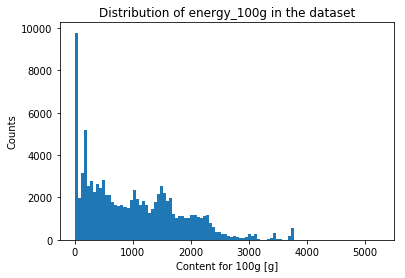

ValueError: max must be larger than min in range parameter.

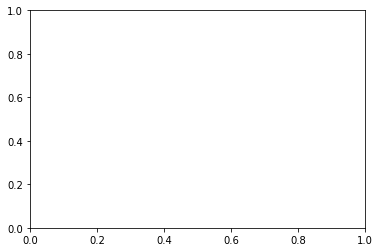

In [35]:
for index in range(2, len(data_food.columns)):
    column = data_food.columns[index]
    plt.hist(data_food[column], bins = 100);
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts');
    plt.xlabel('Content for 100g [g]');
    plt.axis('tight');
    plt.show()

In [36]:
data_food.corr(method ='pearson')

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
energy_100g,1.000000,0.809943,0.612375,0.267042,-0.036578,-0.036583,-0.198880,-0.212953,0.244683,0.209838
fat_100g,0.809943,1.000000,0.739745,-0.100560,-0.003016,-0.003021,-0.160923,-0.242842,0.055652,0.155141
saturated-fat_100g,0.612375,0.739745,1.000000,-0.011782,-0.007740,-0.007740,-0.240508,-0.343563,-0.002782,0.161927
sugars_100g,0.267042,-0.100560,-0.011782,1.000000,-0.090131,-0.090132,0.046411,0.119270,0.010104,-0.281511
salt_100g,-0.036578,-0.003016,-0.007740,-0.090131,1.000000,0.999999,-0.096588,-0.077579,-0.002461,0.062635
sodium_100g,-0.036583,-0.003021,-0.007740,-0.090132,0.999999,1.000000,-0.096586,-0.077575,-0.002463,0.062618
fruits-vegetables-nuts_100g,-0.198880,-0.160923,-0.240508,0.046411,-0.096588,-0.096586,1.000000,0.997619,0.054012,-0.213638
fruits-vegetables-nuts-estimate_100g,-0.212953,-0.242842,-0.343563,0.119270,-0.077579,-0.077575,0.997619,1.000000,0.101369,-0.329394
fiber_100g,0.244683,0.055652,-0.002782,0.010104,-0.002461,-0.002463,0.054012,0.101369,1.000000,0.240352
proteins_100g,0.209838,0.155141,0.161927,-0.281511,0.062635,0.062618,-0.213638,-0.329394,0.240352,1.000000


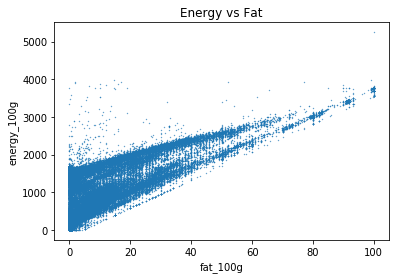

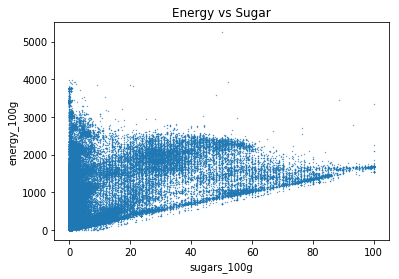

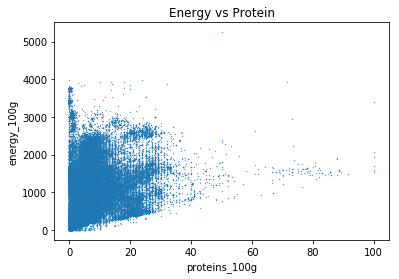

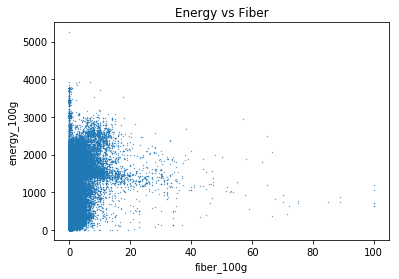

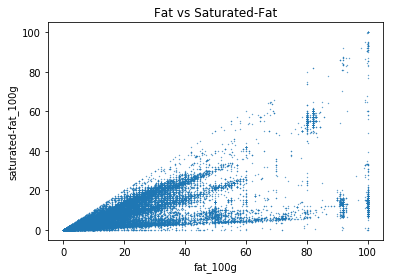

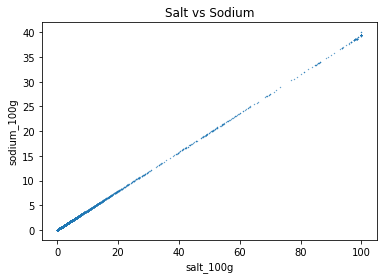

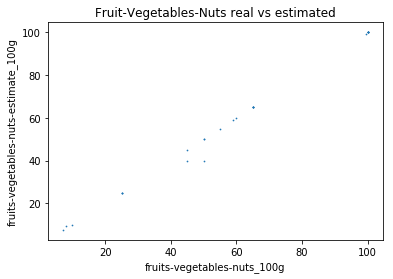

In [37]:
plt.scatter(data_food['fat_100g'],data_food['energy_100g'], s=0.1);
plt.title('Energy vs Fat');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.show()

plt.scatter(data_food['sugars_100g'],data_food['energy_100g'], s=0.1);
plt.title('Energy vs Sugar');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.show()

plt.scatter(data_food['proteins_100g'],data_food['energy_100g'], s=0.1);
plt.title('Energy vs Protein');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.show()

plt.scatter(data_food['fiber_100g'],data_food['energy_100g'], s=0.1);
plt.title('Energy vs Fiber');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.show()

plt.scatter(data_food['fat_100g'],data_food['saturated-fat_100g'], s=0.1);
plt.title('Fat vs Saturated-Fat');
plt.ylabel('saturated-fat_100g');
plt.xlabel('fat_100g');
plt.show()

plt.scatter(data_food['salt_100g'],data_food['sodium_100g'], s=0.1);
plt.title('Salt vs Sodium');
plt.ylabel('sodium_100g');
plt.xlabel('salt_100g');
plt.show()

plt.scatter(data_food['fruits-vegetables-nuts_100g'],data_food['fruits-vegetables-nuts-estimate_100g'], s=0.5);
plt.title('Fruit-Vegetables-Nuts real vs estimated');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.show()

In [38]:
data_nutriscore = data_clean[['nutrition-score-fr_100g','nutrition_grade_fr']]

data_food_nutri = data_food.join(data_nutriscore)

data_food_nutri = data_food_nutri[~data_food_nutri.nutrition_grade_fr.isna()]

data_food_nutri['Predicted_NutriScore_grade'] = np.nan
data_food_nutri['Predicted_NutriScore_score'] = np.nan

for index in range(len(data_food_nutri)):

    product = data_food_nutri.iloc[[index]]
    nutriscore, final_score = computeNutriScore(product)
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score

In [39]:
y_true = data_food_nutri['nutrition_grade_fr']
y_pred = data_food_nutri['Predicted_NutriScore_grade']
labels = ['a', 'b', 'c', 'd', 'e', 'Error']
confusion_matrix_ = confusion_matrix(y_true, y_pred, labels=['a', 'b', 'c', 'd', 'e', 'Error'])
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=labels), index = labels, columns = labels)

,a,b,c,d,e,Error
a,9021,377,130,3,4,2471
b,77,6969,412,45,17,4181
c,57,42,10018,407,17,6817
d,9,19,640,10853,138,12474
e,2,16,250,205,8692,7888
Error,0,0,0,0,0,0


In [40]:
data_food_nutri_beverages = data_food_nutri[data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False)]
data_food_nutri_non_beverages = data_food_nutri[~(data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False))]

In [41]:
print("For Beverages :\n")
ratio_grade = len(data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == data_food_nutri_beverages['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri_beverages)
ratio_score = len(data_food_nutri_beverages[data_food_nutri_beverages['nutrition-score-fr_100g'] == data_food_nutri_beverages['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri_beverages)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.\n'.\
          format(ratio_grade,ratio_score))

print("For non-Beverages :\n")
ratio_grade = len(data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == data_food_nutri_non_beverages['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri_non_beverages)
ratio_score = len(data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition-score-fr_100g'] == data_food_nutri_non_beverages['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri_non_beverages)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.\n'.\
          format(ratio_grade,ratio_score))

For Beverages :

The accuracy according to the grade is 95.26387009472259 %, the accuracy according to the score is 86.64042317628244 %.

For non-Beverages :

The accuracy according to the grade is 51.00914708183805 %, the accuracy according to the score is 47.09398019481396 %.



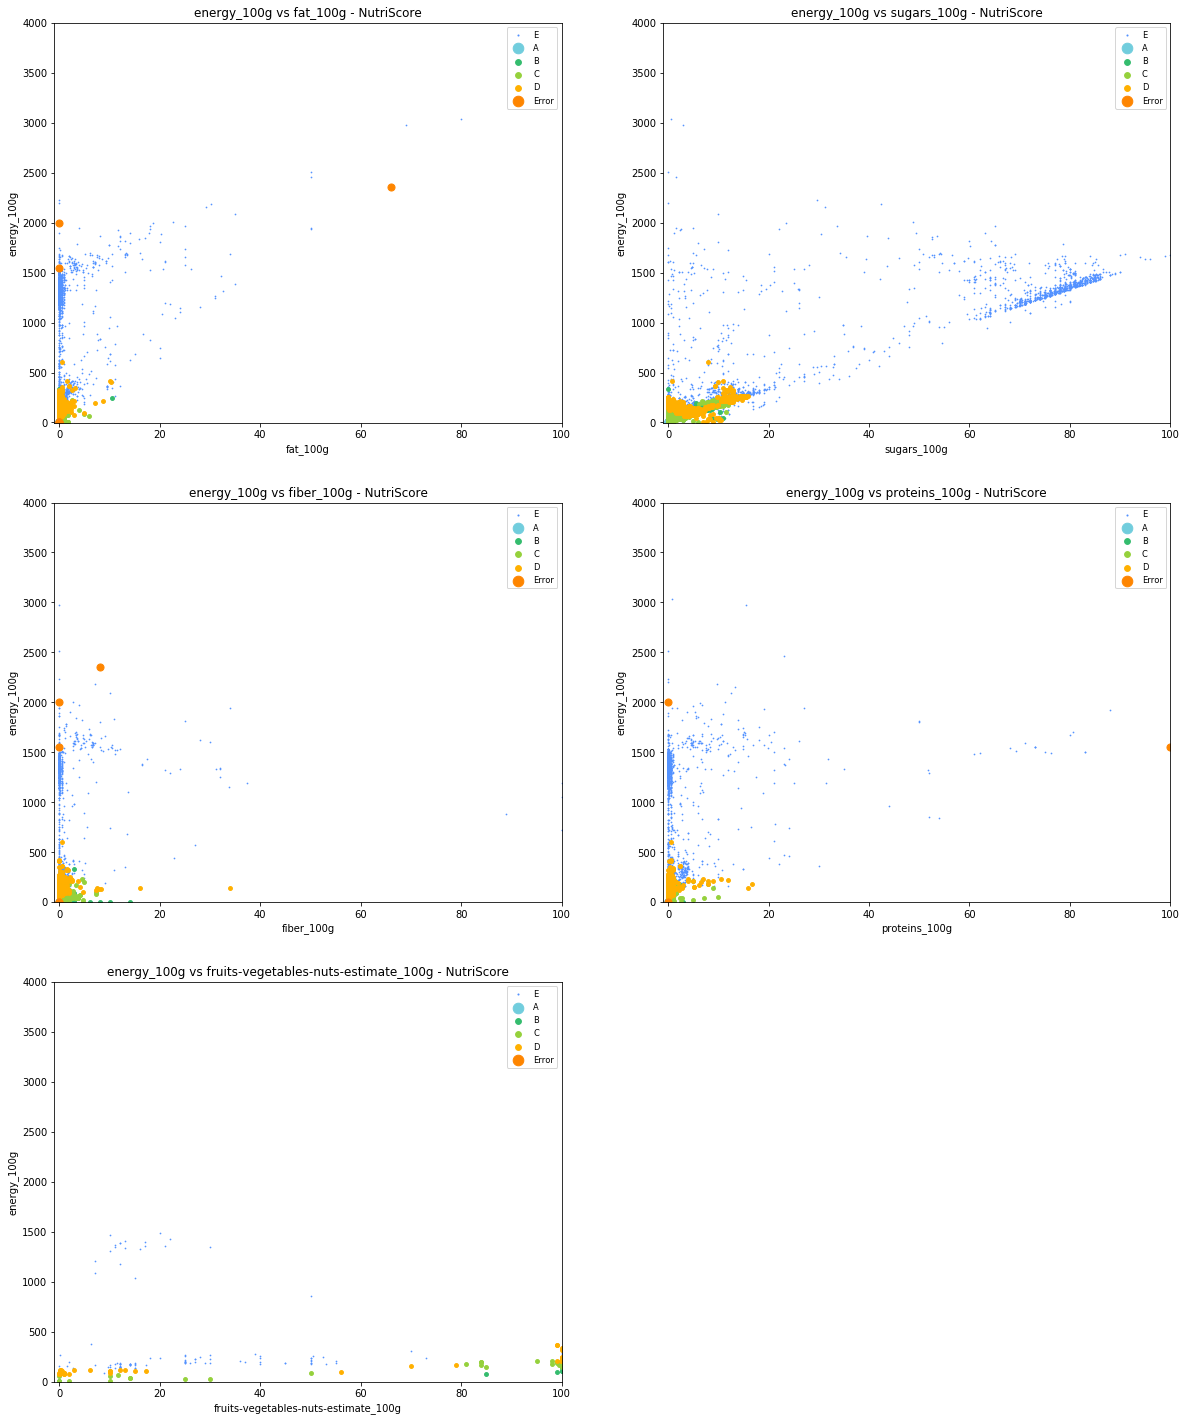

In [42]:
data_food_nutri_beverages_A = data_food_nutri_beverages[data_food_nutri_beverages['Predicted_NutriScore_grade'] == 'a']
data_food_nutri_beverages_B = data_food_nutri_beverages[data_food_nutri_beverages['Predicted_NutriScore_grade'] == 'b']
data_food_nutri_beverages_C = data_food_nutri_beverages[data_food_nutri_beverages['Predicted_NutriScore_grade'] == 'c']
data_food_nutri_beverages_D = data_food_nutri_beverages[data_food_nutri_beverages['Predicted_NutriScore_grade'] == 'd']
data_food_nutri_beverages_E = data_food_nutri_beverages[data_food_nutri_beverages['Predicted_NutriScore_grade'] == 'e']
data_food_nutri_beverages_Error = data_food_nutri_beverages[data_food_nutri_beverages['Predicted_NutriScore_grade'] == 'Error']

Color = ['#5392ff','#71cddd', '#34bc6e', '#95d13c', '#ffb000', '#fe8500']


fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_beverages_E['fat_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

ax.scatter(data_food_nutri_beverages_A['fat_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['fat_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['fat_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['fat_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);

ax.scatter(data_food_nutri_beverages_Error['fat_100g'],data_food_nutri_beverages_Error['energy_100g'], label = 'Error', s = 50);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_beverages_E['sugars_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

ax.scatter(data_food_nutri_beverages_A['sugars_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['sugars_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['sugars_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['sugars_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);

ax.scatter(data_food_nutri_beverages_Error['sugars_100g'],data_food_nutri_beverages_Error['energy_100g'], label = 'Error', s = 50);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_beverages_E['fiber_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

ax.scatter(data_food_nutri_beverages_A['fiber_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['fiber_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['fiber_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['fiber_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);

ax.scatter(data_food_nutri_beverages_Error['fiber_100g'],data_food_nutri_beverages_Error['energy_100g'], label = 'Error', s = 50);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_beverages_E['proteins_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

ax.scatter(data_food_nutri_beverages_A['proteins_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['proteins_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['proteins_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['proteins_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);

ax.scatter(data_food_nutri_beverages_Error['proteins_100g'],data_food_nutri_beverages_Error['energy_100g'], label = 'Error', s = 50);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_beverages_E['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 0.5);

ax.scatter(data_food_nutri_beverages_A['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 50);
ax.scatter(data_food_nutri_beverages_B['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 15);
ax.scatter(data_food_nutri_beverages_C['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 15);
ax.scatter(data_food_nutri_beverages_D['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 15);

ax.scatter(data_food_nutri_beverages_Error['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_Error['energy_100g'], label = 'Error', s = 50);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 1.5);

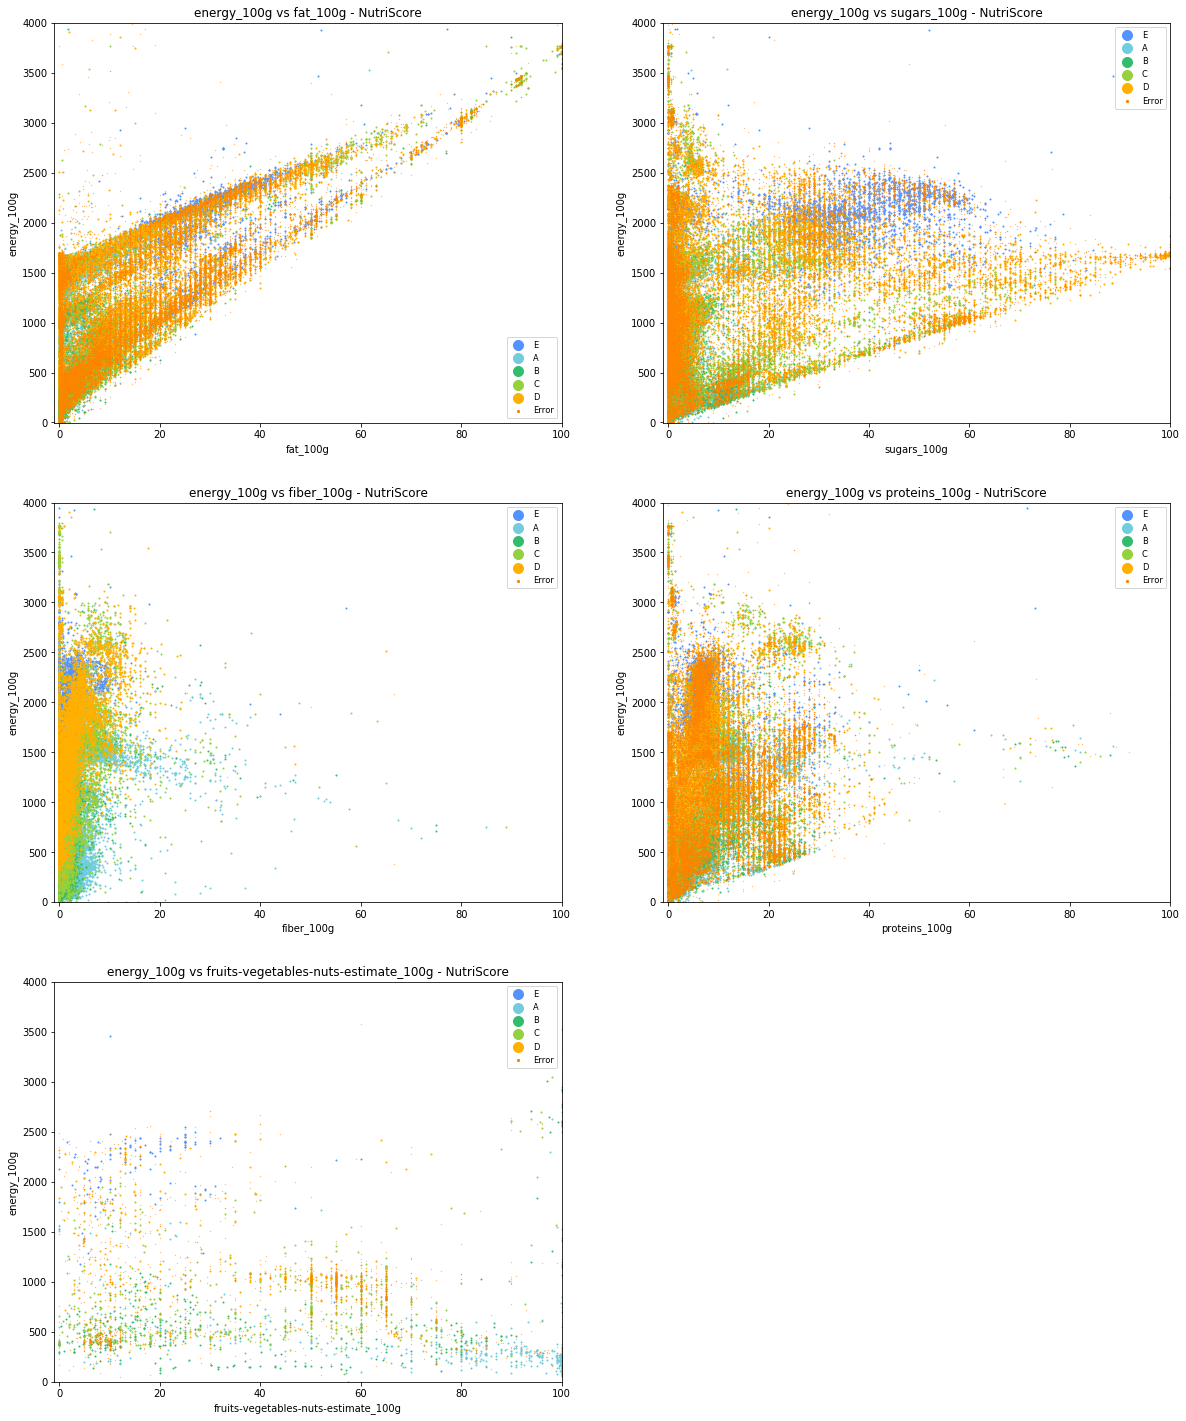

In [43]:
data_food_nutri_non_beverages_A = data_food_nutri_non_beverages[data_food_nutri_non_beverages['Predicted_NutriScore_grade'] == 'a']
data_food_nutri_non_beverages_B = data_food_nutri_non_beverages[data_food_nutri_non_beverages['Predicted_NutriScore_grade'] == 'b']
data_food_nutri_non_beverages_C = data_food_nutri_non_beverages[data_food_nutri_non_beverages['Predicted_NutriScore_grade'] == 'c']
data_food_nutri_non_beverages_D = data_food_nutri_non_beverages[data_food_nutri_non_beverages['Predicted_NutriScore_grade'] == 'd']
data_food_nutri_non_beverages_E = data_food_nutri_non_beverages[data_food_nutri_non_beverages['Predicted_NutriScore_grade'] == 'e']
data_food_nutri_non_beverages_Error = data_food_nutri_non_beverages[data_food_nutri_non_beverages['Predicted_NutriScore_grade'] == 'Error']

Color = ['#5392ff','#71cddd', '#34bc6e', '#95d13c', '#ffb000', '#fe8500']


fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_non_beverages_E['fat_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

ax.scatter(data_food_nutri_non_beverages_A['fat_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fat_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fat_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fat_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);

ax.scatter(data_food_nutri_non_beverages_Error['fat_100g'],data_food_nutri_non_beverages_Error['energy_100g'], label = 'Error', s = 0.05);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_non_beverages_E['sugars_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

ax.scatter(data_food_nutri_non_beverages_A['sugars_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['sugars_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['sugars_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['sugars_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);

ax.scatter(data_food_nutri_non_beverages_Error['sugars_100g'],data_food_nutri_non_beverages_Error['energy_100g'], label = 'Error', s = 0.05);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_non_beverages_E['fiber_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

ax.scatter(data_food_nutri_non_beverages_A['fiber_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fiber_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fiber_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fiber_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);

ax.scatter(data_food_nutri_non_beverages_Error['fiber_100g'],data_food_nutri_non_beverages_Error['energy_100g'], label = 'Error', s = 0.05);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_non_beverages_E['proteins_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

ax.scatter(data_food_nutri_non_beverages_A['proteins_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['proteins_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['proteins_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['proteins_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);

ax.scatter(data_food_nutri_non_beverages_Error['proteins_100g'],data_food_nutri_non_beverages_Error['energy_100g'], label = 'Error', s = 0.05);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);
ax.scatter(data_food_nutri_non_beverages_E['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

ax.scatter(data_food_nutri_non_beverages_A['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);

ax.scatter(data_food_nutri_non_beverages_Error['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_Error['energy_100g'], label = 'Error', s = 0.05);
for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);